# Reddit Stock Subreddit Analysis
## by Scott Levin
### February, 2018

What makes a Reddit post successful? Because Reddit functions as a discussion-based online

community, posts that drive conversation are generally considered 'successful'. In this 

regard, there is no better metric to measure conversation than the number of comments a post 

recieves. I web scraped all submissions to Reddit's 'Stock' subreddit from September 1st 

through February 19th in order to analyze the characteristics of posts with a high (and low) 

number of comments. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords 
import re
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from PIL import Image
from wordcloud import WordCloud
%matplotlib inline

The data was scraped using PRAW

In [2]:
df = pd.read_csv('stocks_from_sep.csv', index_col=0)

In [3]:
#Creating a variable for the length of the title (number of characters). 
df['Length'] = df['title'].apply(len)

(5566, 6)

### Looking at the distributions of my numeric variables... 

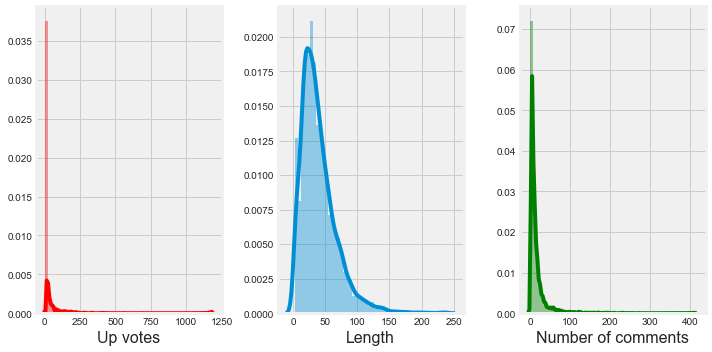

In [790]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
sns.distplot(df['up_votes'],ax=axes[0], color='red')
sns.distplot(df['Length'],ax=axes[1])
sns.distplot(df['number_of_comments'], ax=axes[2], color='green')
axes[0].set_xlabel('Up votes', fontdict={'fontsize': 16})
axes[1].set_xlabel('Length', fontdict={'fontsize': 16})
axes[2].set_xlabel('Number of comments', fontdict={'fontsize': 16})

plt.tight_layout()

In [474]:
#Identifying the median value to use as the response value and creating this column as a dummy variable. 
df['number_of_comments'].median()
df['median_com'] = (df['number_of_comments'] > 6).astype(int)

In [475]:
df.head()

,date_created,is_video,number_of_comments,title,up_votes,Length,median_com
0,2018-02-19 16:14:30,False,2,A Natural monopoly stock - growth question.,1,43,0
1,2018-02-19 15:07:47,False,0,Fund changing from Close end to Open end. Effe...,2,50,0
2,2018-02-19 12:41:08,False,6,AbbVie (ABBV),21,13,0
3,2018-02-19 08:36:12,False,0,Weekly Trade Update for Feb-16-2018,0,35,0
4,2018-02-19 08:13:34,False,3,Is this a good/bad deal? Offered shares at the...,4,75,0


In [476]:
#Gathering all string data from the title variable into one long string. 
txt = ''
for val in df['title']:
    txt = txt + ' ' + val

In [477]:
#There are 1287 digit values in the titles, or roughly 31 'words' for every numerical value in a title. 
tokenizer = RegexpTokenizer(r'\d+')
tokens = tokenizer.tokenize(txt)
len(tokens)

1287

In [478]:
#Second, I want to understand the overall makeup of the title texts. Initially looking only at word values. 
#Only 14% of words are unique.
tokenizer = RegexpTokenizer(r'\w+')
tokens = tokenizer.tokenize(txt.lower())
len(set(tokens))/len(tokens)
len(tokens)/1287

30.954156954156954

In [479]:
#creating a dummy variable if the title contains a numeric character. 
nums = []
for val in df['title']:
    p = re.findall(r'\d+', val)
    if p:
        nums.append(1)
    else:
        nums.append(0)
df['contains_num'] = nums

In [480]:
#There are no video posts for this subreddit, dropping these values. 
df = df.drop('is_video', axis=1)

In [481]:
#Initializing lemmatizer 

lemmatizer = WordNetLemmatizer()
stop = set(stopwords.words('english'))
stop.add('would') 

def cleaner(title):
    """ This function accepts a string, tokenizes it, removes stopwords,
    lemmatizes them, and then return the words as a joined string"""
    tokenizer = RegexpTokenizer(r'\w+')
    no_chars = re.sub(r"[^a-zA-Z]", " ", title)
    titles = tokenizer.tokenize(no_chars.lower())
    lst = [word for word in titles if word not in stop and len(word) > 1]
    lemons = [lemmatizer.lemmatize(word) for word in lst]
    final = ' '.join(lemons)
    return final

df['tokens'] = df['title'].apply(cleaner)

In [482]:
df['date_created'] = pd.to_datetime(df['date_created'])

### Transforming titles into features with countvectorizer

In [483]:
cvec = CountVectorizer()
cvec.fit(df['tokens'])
cvecdata = cvec.transform(df['tokens'])

In [484]:
feature_df = pd.DataFrame(cvecdata.todense(), 
                           columns=cvec.get_feature_names())

### What are the 10 most common title words? 

In [485]:
feature_df.T.sum(axis=1).sort_values(ascending=False).head(10)

stock       1182
thought      353
buy          290
market       268
good         193
question     174
company      174
long         156
earnings     153
etf          149
dtype: int64

### What about the sparsity? Only 0.087% of values are non-zero. 

In [486]:
sparsity = (100 * feature_df.astype(bool).sum(axis=0).sum() / 
            (feature_df.shape[0] * feature_df.shape[1]))
print('Sparsity: ', sparsity)

Sparsity:  0.0869913916273


### Without any further cleaning/parameters, how accurately can we predict 'popular' reddit posts using only word frequencies in logistic regression?

In [487]:
def logreg(X, y):
    
    """A basic logistic regression function, prints accuracy score and
    a simple confusion matrix, returns the train/test sets and model"""
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=42)

    lr = LogisticRegression()
    
    lr.fit(X_train, y_train)
    
    predictions = lr.predict(X_test)
    
    print(pd.crosstab(y_test, predictions, rownames=['Actual'], 
                           colnames=['Predicted'], margins=True), '\n')
    print('Overall accuracy:', accuracy_score(y_test, predictions))
    
    return X_train, X_test, y_train, y_test, lr

In [488]:
X = feature_df.copy()
y = df.median_com

X_train, X_test, y_train, y_test, lr = logreg(X, y)

Predicted    0    1   All
Actual                   
0          560  269   829
1          311  530   841
All        871  799  1670 

Overall accuracy: 0.652694610778


### Now let's take a look at the most important 'word features'...

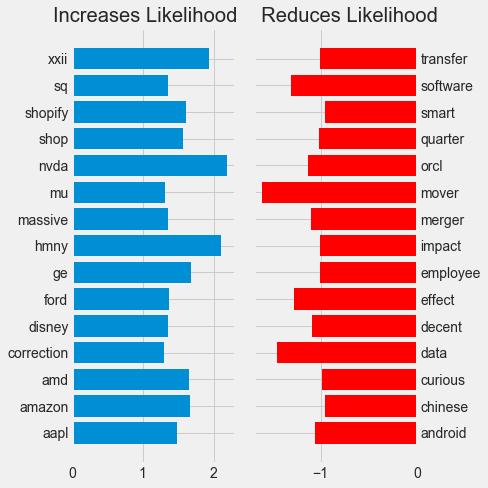

In [489]:
test_df = pd.DataFrame(lr.coef_[0], index=X_train.columns, 
                       columns=['coefficients'])

important_vars = pd.DataFrame(test_df['coefficients'].sort_values(
                    ascending=False).head(15)).reset_index()

important_vars2 = pd.DataFrame(test_df['coefficients'].sort_values(
                                            ).head(15)).reset_index()

sns.set_style('darkgrid')
plt.style.use('fivethirtyeight')

fig, axes = plt.subplots(ncols=2, figsize=(7, 7))

axes[0].barh(important_vars['index'], important_vars['coefficients'], 
             align='center')
axes[1].barh(important_vars2['index'], important_vars2['coefficients']
             , align='center',color='red')

axes[1].yaxis.tick_right()
axes[0].set(title='Increases Likelihood   ')
axes[1].set(title='     Reduces Likelihood')

plt.rcParams.update({'font.size': 14})
plt.tight_layout()

### Many of these are stock labels: 

    * xxii = 22nd century group  * ge = General Electric
    * sq = Square inc.           * amd = Advanced Micro Devices
    * aapl = Apple               * hmny = Helios and Matheson Analytics 
    * nvda = Nvidia              * orcl = Oracle

### What if we do the same thing, but add in a few additional features?

In [490]:
X = pd.concat([feature_df, df[['Length', 'contains_num']]], axis=1)
y = df.median_com

X_train, X_test, y_train, y_test, lr = logreg(X, y)

Predicted    0    1   All
Actual                   
0          566  263   829
1          308  533   841
All        874  796  1670 

Overall accuracy: 0.658083832335


### Less than a 1% improvement... Perhaps there is too much noise? 
How much do these variables explain on their own? 

In [491]:
#Dropped 'contains a number' because it was statistically insignificant.
#Of cou
X = df[['Length', 'contains_num']]
y = df.median_com

X_train, X_test, y_train, y_test, lr = logreg(X, y)

Predicted     0    1   All
Actual                    
0           615  214   829
1           556  285   841
All        1171  499  1670 

Overall accuracy: 0.538922155689


Correlation between Length/Up_Votes:  
 0.117837598393
Correlation between Median_Comments/Up_Votes:  
 0.243566459137
Correlation between Median_Comments/Contains_Number:  
 0.0723432056072
Correlation between Median_Comments/Length:  
 0.0636586441287


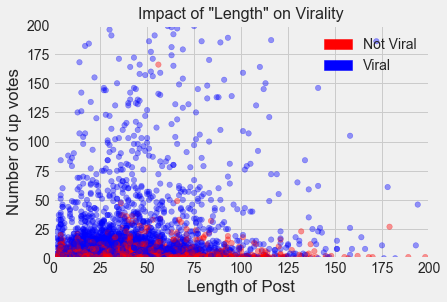

In [492]:
color_map = {1: 'b', 0:'r'}
fig, ax = plt.subplots()
ax.scatter(df['Length'], df['up_votes'], 
           c=[color_map[i] for i in df['median_com']], alpha=0.4,s=30)
ax.set_ylim(0, 200)
ax.set_xlim(0, 200)
legend_patch = mpatches.Patch(color='red', label='Not Viral')
legend_patch2 = mpatches.Patch(color='blue', label='Viral')                            
plt.legend(handles=[legend_patch, legend_patch2])
ax.set_xlabel('Length of Post')
ax.set_ylabel('Number of up votes')
ax.set_title('Impact of "Length" on Virality', fontdict={'fontsize': 16})

print('Correlation between Length/Up_Votes: ', '\n', 
      np.corrcoef(df['Length'].values, df['up_votes'].values)[0][1])
print('Correlation between Median_Comments/Up_Votes: ', '\n', 
      np.corrcoef(df['median_com'].values, df['up_votes'].values)[0][1])
print('Correlation between Median_Comments/Contains_Number: ', '\n', 
      np.corrcoef(df['median_com'].values, df['contains_num'].values)[0][1])
print('Correlation between Median_Comments/Length: ', '\n', 
      np.corrcoef(df['median_com'].values, df['Length'].values)[0][1])

Text(0.5,1,"Length's Effect on Virality")

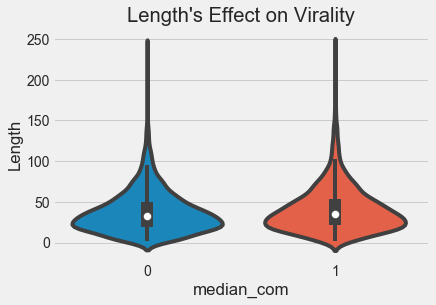

In [493]:
fig, ax = plt.subplots()
sns.violinplot(df.median_com, df.Length, )
ax.set_title('Length\'s Effect on Virality')

### K-nearest Neighbors accurate predicted ~54% of values correctly

In [494]:
X = feature_df
y = df.median_com
    
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=42)

knn5 = KNeighborsClassifier(n_neighbors=10)
knn5.fit(X_train, y_train)
predictions = knn5.predict(X_test)
print(accuracy_score(y_test, predictions))

0.538922155689


In [495]:
svm = SVC()

svm.fit(X_train, y_train)
predictions = svm.predict(X_test)
accuracy_score(y_test, predictions)

0.49640718562874253

In [496]:
tdif = TfidfTransformer()
X = tdif.fit_transform(feature_df)

In [497]:
X_train, X_test, y_train, y_test, lr = logreg(X, y)

Predicted    0    1   All
Actual                   
0          588  241   829
1          328  513   841
All        916  754  1670 

Overall accuracy: 0.659281437126


In [498]:
new = pd.DataFrame(X.todense(), columns=feature_df.columns)
word_values = new.sum(axis=0).sort_values(ascending=False).reset_index().T
word_values.columns = word_values.iloc[0, :]
word_values = word_values.drop('index', axis=0)
#dropping 30% of the columns by Tfid weight
best_words = word_values.iloc[:, :int((4803 * .7))]

In [499]:
#Merging the useful words onto the Tfid data frame
new_df = pd.DataFrame(X.todense(), columns=feature_df.columns)
X = new_df[list(best_words.columns)]
X_train, X_test, y_train, y_test, lr = logreg(X, y)

Predicted    0    1   All
Actual                   
0          591  238   829
1          330  511   841
All        921  749  1670 

Overall accuracy: 0.659880239521


### What happens when you widen the gap for the median? i.e. eliminate observations close to the boundry (6) . There is likely little difference in the title of a post that recieves 6 vs. 7 comments... 

In [551]:
#I have 5566 observations, 1335 observations have 0, 1 or 2 comments.
len(df.loc[(df.number_of_comments.isin([0,1, 2]))])
len(df.loc[(df.number_of_comments > 8)])

sep_df = df.loc[(df.number_of_comments < 3) | (df.number_of_comments > 13)]

#The classes are now separated (no values between 2 and 14)
sep_df['median_com'].value_counts()

1    1492
0    1335
Name: median_com, dtype: int64

In [552]:
#Not surprisingly- creating a larger gap between the # of comments allows
#for improved accuracy. 
cvec = CountVectorizer()
cvecdata = cvec.fit_transform(sep_df['tokens'])
X = pd.DataFrame(cvecdata.todense(), columns=cvec.get_feature_names())
y = sep_df['median_com']

X_train, X_test, y_train, y_test, lr = logreg(X, y)

Predicted    0    1  All
Actual                  
0          277  137  414
1           89  346  435
All        366  483  849 

Overall accuracy: 0.733804475854


### How many words are common between viral/not viral titles? 

In [553]:
#Getting the most common words from 'viral' titles
from collections import Counter
tokenizer = RegexpTokenizer(r'\w+')
words = list(sep_df.loc[sep_df['median_com'] == 1]['tokens'].values)
blanks = []
for word in words:
    blanks.extend(tokenizer.tokenize(word))
common_viral = Counter(blanks).most_common(100)
common_viral = [word[0] for word in common_viral]

In [554]:
#Getting most common words from not 'viral' titles
words = list(sep_df.loc[sep_df['median_com'] == 0]['tokens'].values)
blanks = []
for word in words:
    blanks.extend(tokenizer.tokenize(word))
not_viral = Counter(blanks).most_common(100)
not_viral = [word[0] for word in not_viral]

### Of the 100 most common words in each set, 52 are common to both! 

In [555]:
unique_not_viral = [word for word in not_viral if not word in common_viral]
unique_viral = [word for word in common_viral if not word in not_viral]
common_both = [word for word in common_viral if word in not_viral]
len(unique_not_viral)

48

### Let's look at a cool visualization of the word differences and similarities...

In [556]:
def word_image(list_of_words, file_loc, title, scale1, scale2):
   
    """Creates a word cloud with a particular image in a grey scale"""
    
    def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
        return "hsl(600, 0%%, %d%%)" % np.random.randint(scale1, scale2)

    mask = np.array(Image.open(file_loc))
    plt.figure(figsize=(12, 8))
    wordcloud = WordCloud(mask=mask, background_color='white').generate(' '.join(
                                [word for word in list_of_words]))
    
    plt.imshow(wordcloud.recolor(color_func=grey_color_func), interpolation='bilinear')
    plt.title(title, fontdict={'fontsize': 30})
    plt.axis('off')

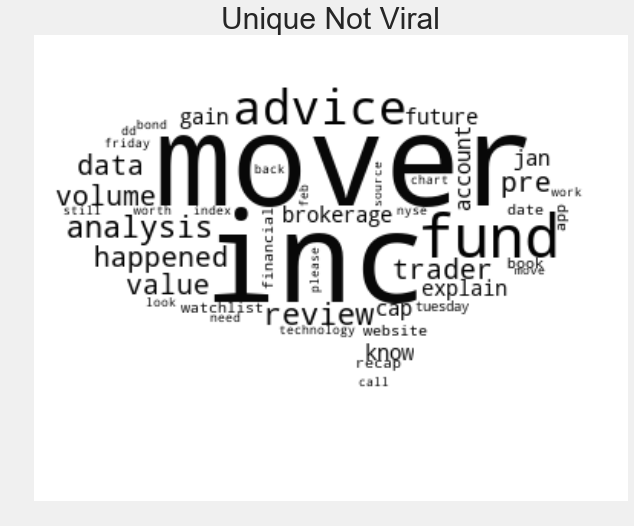

In [557]:
word_image(unique_not,'./outline.png', 'Unique Not Viral', 0, 4)

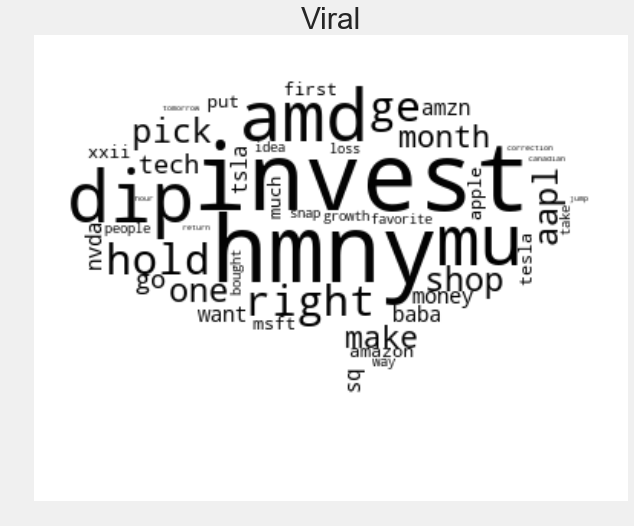

In [558]:
word_image(unique_viral,'./outline.png', 'Viral', 0, 4 )

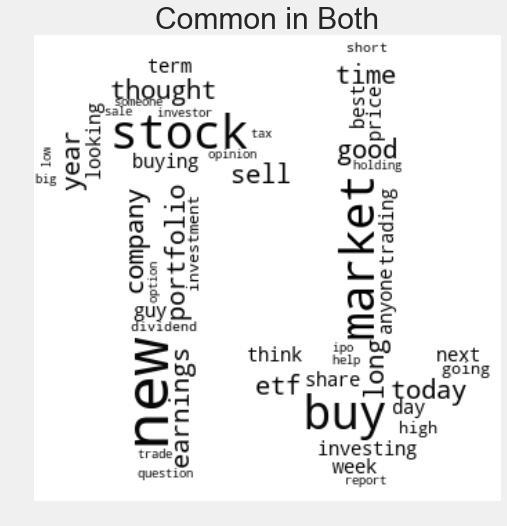

In [559]:
word_image(common_both, './arrow2.jpg', 'Common in Both', 0, 4)

### What is the impact of posting on a weekday vs. weekend? 

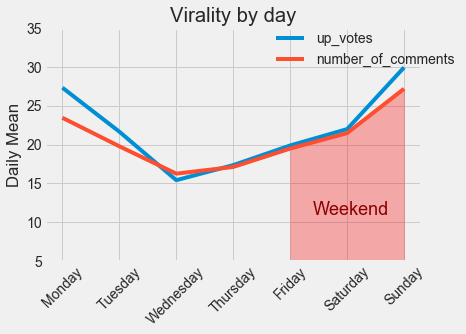

In [563]:
#Getting day of week from date_created and then plotting

sep_df = sep_df.copy()
weekdays = sep_df['date_created'].dt.weekday_name
sep_df['day_of_week'] = weekdays


by_day = sep_df.groupby('day_of_week', as_index=False)['up_votes', 'number_of_comments'].mean()

by_day['day_of_week'] = pd.Categorical(by_day['day_of_week'], categories=['Monday','Tuesday','Wednesday','Thursday',
                                         'Friday','Saturday', 'Sunday'], ordered=True)

by_day = by_day.sort_values(by='day_of_week').reset_index(drop=True)

y = by_day['number_of_comments'][-3:].values
x = np.array([4, 5, 6])

fig, axes = plt.subplots()

axes.plot(by_day['up_votes'],  label='up_votes')
axes.plot(by_day['number_of_comments'],label='number_of_comments')
axes.set_xticklabels(['', 'Monday','Tuesday','Wednesday','Thursday', 'Friday','Saturday', 'Sunday'], rotation=45)
axes.set_ylabel('Daily Mean')
axes.fill_between(x, y, color='red', alpha=0.3)
axes.set_ylim(5, 35)
axes.text(4.4, 11, 'Weekend', fontdict={'size': 18, 'color':'darkred'})
plt.title('Virality by day')
plt.legend(loc=(.6, .81))

In [564]:
print("Difference in posting on a weekday vs. weekend: ", '\n',
    (by_day.loc[by_day['day_of_week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday'])].mean()
- by_day.loc[by_day['day_of_week'].isin(['Friday', 'Saturday', 'Sunday'])].mean()))

Difference in posting on a weekday vs. weekend:  
 up_votes             -3.494173
number_of_comments   -3.560413
dtype: float64


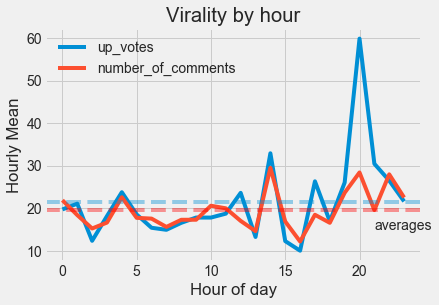

In [565]:
sep_df['hour'] = sep_df['date_created'].dt.hour

by_hour = sep_df.groupby('hour')['up_votes', 'number_of_comments'].mean()

fig, axes = plt.subplots()

axes.plot('up_votes', data=by_hour, label='up_votes')
axes.plot('number_of_comments', data=by_hour, label='number_of_comments')
axes.axhline(y =by_hour.up_votes.mean(), linestyle='dashed', alpha=0.4 )
axes.axhline(y=by_hour.number_of_comments.mean(), linestyle='dashed', color='red', alpha=0.4)
axes.set_xlabel('Hour of day')
axes.set_ylabel('Hourly Mean')
axes.text(21, 15, 'averages')
plt.title('Virality by hour')
plt.legend()

### What if we create dummy variables for evening (5pm -12am) and weekend (Fri, Sat, Sun)? (positive correlation with median_comment is ~0.08 for both)

In [566]:
sep_df['weekend'] = (sep_df['day_of_week'].isin(['Friday', 'Saturday', 'Sunday'])).astype(int)
sep_df['evening'] = (sep_df['hour'].isin([17,18,19,20,21,22,23])).astype(int)

### Adding these variables to the word counts doesn't import accuracy (also 73%)
#### Alone these variables only accurately predict 54% accurately

In [567]:
#X = pd.DataFrame(cvecdata.todense(), columns=cvec.get_feature_names())
X = sep_df[['weekend', 'evening']].reset_index(drop=True)
y = sep_df['median_com']

X_train, X_test, y_train, y_test, lr = logreg(X, y)

Predicted    0    1  All
Actual                  
0          206  208  414
1          181  254  435
All        387  462  849 

Overall accuracy: 0.541813898704


### What if the sentences differ in structure? Could the parts of speech tell us something?

In [611]:
#Separating and preparing through tokenization

viral = sep_df.loc[sep_df['median_com'] == 1]
not_viral = sep_df.loc[sep_df['median_com'] == 0]

tokenizer = RegexpTokenizer(r'\w+')

tokens_viral = tokenizer.tokenize(' '.join(string for string in viral['tokens'].values))
tokens_not = tokenizer.tokenize(' '.join(string for string in not_viral['tokens'].values))

#Separating parts of speech from the words

part_speech_viral = [x[1] for x in nltk.pos_tag(tokens_viral)]
part_speech_not = [x[1] for x in nltk.pos_tag(tokens_not)]

In [717]:
#Putting into dataframes and getting ready to look at make-up
part_speech_counts_viral = dict(Counter(part_speech_viral))
part_speech_counts_not = dict(Counter(part_speech_not))

viral = pd.DataFrame(part_speech_counts_viral, index=['Count']).T.sort_values(
                                                    by='Count',ascending=False).reset_index()
not_viral = pd.DataFrame(part_speech_counts_not, index=['Count']).T.sort_values(
                                                    by='Count',ascending=False).reset_index()



not_viral['percent_not'] = not_viral['Count'].transform(lambda x: x / x.sum()).values
viral['percent_vir'] = viral['Count'].transform(lambda x: x / x.sum()).values
merged_df = pd.merge(not_viral, viral, on='index', how='outer')

In [737]:
#merged_df = merged_df.drop(0,axis=0)
merged_df = merged_df.drop(1, axis=0)

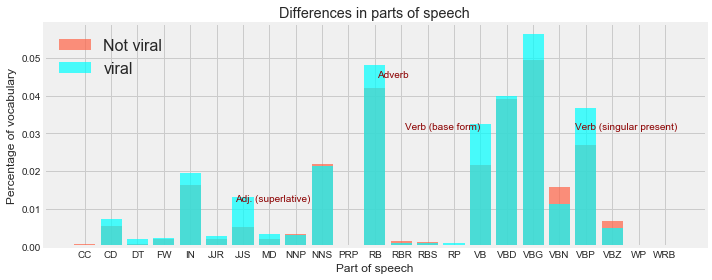

In [789]:
#Removing noun singular common because it dominates the visual. 

fig, axes = plt.subplots(figsize=(10, 4))

axes.bar(merged_df['index'], merged_df['percent_not'], color='tomato', alpha=0.7, label='Not viral')
axes.bar(merged_df['index'], merged_df['percent_vir'], color='aqua',alpha=0.7, label='viral' )
plt.legend(fontsize=16)
plt.ylabel('Percentage of vocabulary')
plt.xlabel('Part of speech')
plt.title('Differences in parts of speech')
axes.text(12.15, 0.031, 'Verb (base form)', fontdict={'size': 10, 'color':'darkred'})
axes.text(18.6, 0.031, 'Verb (singular present)', fontdict={'size': 10, 'color':'darkred'})
axes.text(5.7, 0.012, 'Adj. (superlative)', fontdict={'size': 10, 'color':'darkred'})
axes.text(11.1, 0.045, 'Adverb', fontdict={'size': 10, 'color':'darkred'})
plt.tight_layout()